In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

import pandas as pd
from IPython.display import Image
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.acquisition.analytic import UpperConfidenceBound
import warnings
import gymnasium as gym
import umap
import importlib
import optuna

In [2]:
import env.make
import env.eval
import env.dataset
import utils.utils as utils
importlib.reload(env.make)
importlib.reload(env.eval)
importlib.reload(env.dataset)
importlib.reload(utils);

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
DEVICE = utils.find_device(force_cpu=False)

Using device cuda


In [5]:
FIG_FOLDER, BACKUP_FOLDER = utils.make_folders()

Figures folder: ./figures
Backup folder: ./backup


# Create env and fix horizon

In [6]:
ENV = env.make.mujoco_cartpole()
TIME_HORIZON = 20

# Creating a dataset

In [7]:
train_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=1234)
test_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=12345)

Sampling trajectories and evaluating them...
n=2000; avg = 0.303 +/- 0.166; range  = 0.150, 1.000
Sampling trajectories and evaluating them...
n=2000; avg = 0.296 +/- 0.160; range  = 0.150, 1.000


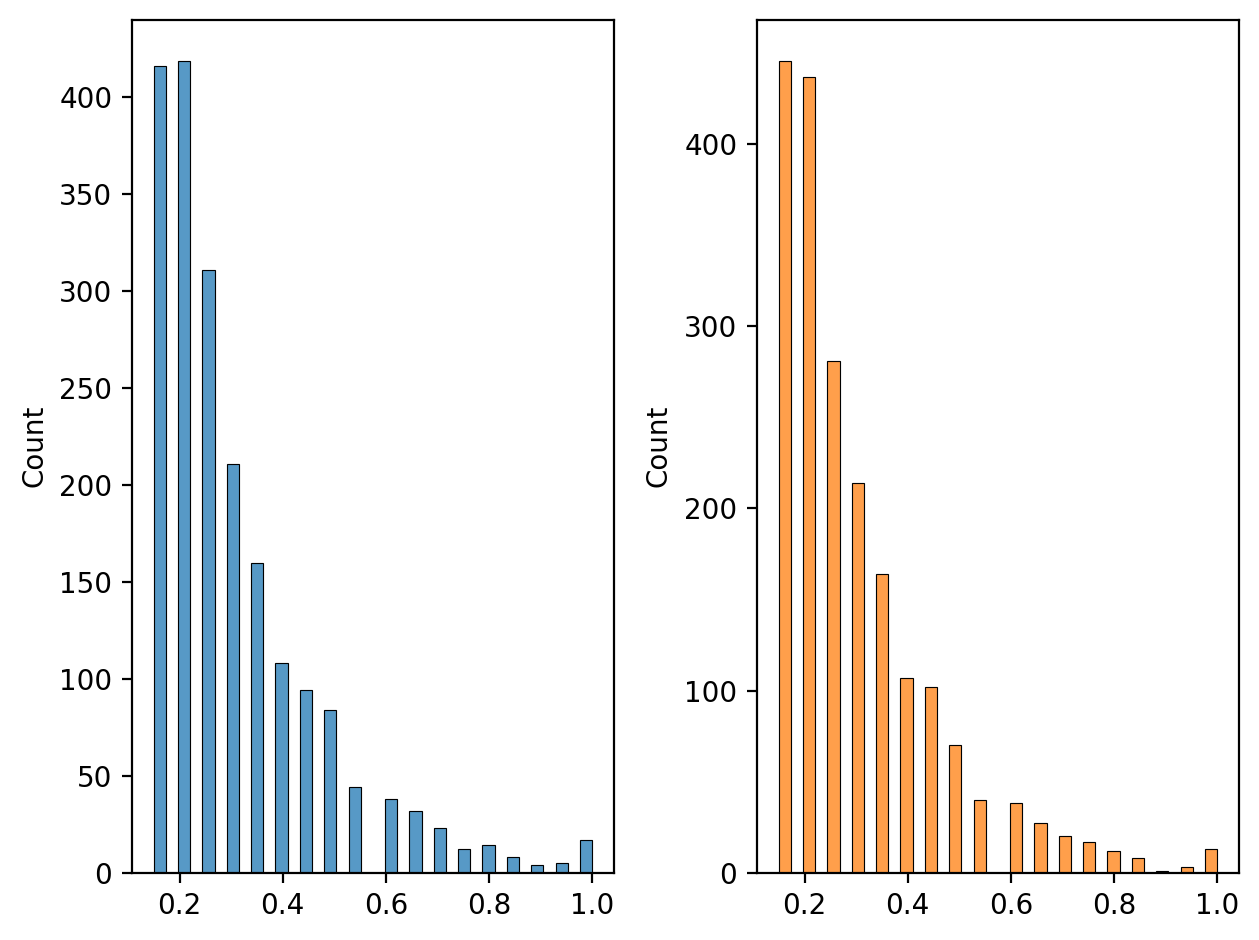

In [8]:
fig, axes = plt.subplots(ncols=2)
sns.histplot(ax=axes[0], x=train_dataset.y.cpu().numpy())
sns.histplot(ax=axes[1], x=test_dataset.y.cpu().numpy(), color="C1")
plt.tight_layout();

# AE

## Defining the AE model

In [15]:
class AE(nn.Module):
    # https://github.com/chrisvdweth/ml-toolkit/blob/master/pytorch/models/text/autoencoder/textrnnvae.py
    def __init__(self, time_horizon, z_dim, device, hidden_dim, num_layers, bidirectional, dropout):
        super().__init__()
        
        # References
        self.num_layers, self.hidden_dim, self.device = num_layers, hidden_dim, device
        self.time_horizon, self.num_directions = time_horizon, 2 if bidirectional else 1

        # For encoder
        self.enc = nn.GRU(
            input_size=1, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True)
        
        self.enc_linear = nn.Linear(hidden_dim*num_layers*self.num_directions, z_dim)
        # self.mu = nn.Linear(hidden_dim*num_layers, z_dim)
        # self.logvar = nn.Linear(hidden_dim*num_layers, z_dim)

        # For decoder 
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim*num_layers*self.num_directions)
        self.out_to_seq = nn.Linear(hidden_dim*self.num_directions, 1)
        
        self.dec = nn.GRU(
            input_size=1, 
            hidden_size=hidden_dim, 
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True)
        
    def encode(self, x):
        x = x.unsqueeze(-1)
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_dim).to(self.device) 
        out, h = self.enc(x, h0)
        # (num_layers*num_directions, batch_size, hidden_dim)  ==>
        # (batch_size, num_directions*num_layers, hidden_dim)  ==>
        # (batch_size, num_directions*num_layers*hidden_dim)
        h = h.transpose(0, 1).contiguous().view(batch_size, -1)
        
        z = self.enc_linear(h)
        # mu = self.mu(h)
        # logvar = self.logvar(h)
        return z # mu , logvar

    #def reparameterize(self, mu, logvar):
    #    std = torch.exp(0.5*logvar)
    #    eps = torch.randn_like(std)
    #    return mu + eps*std

    def decode(self, z):
        batch_size = z.shape[0]
        h = self.z_to_hidden(z)

        # (batch_size, num_directions*num_layers*hidden_dim)    ==>
        # (batch_size, num_directions*num_layers, hidden_dim) ==>
        # (num_layers * num_directions, batch_size, hidden_dim) ==>
        h = h.view(batch_size, self.num_layers*self.num_directions, self.hidden_dim).transpose(0, 1).contiguous()
        input = torch.ones(batch_size, 1, 1).to(self.device)
        x = torch.empty((batch_size, self.time_horizon)).to(self.device)
        for step in range(self.time_horizon):
            out, h = self.dec(input, h)
            seq = self.out_to_seq(out.squeeze())
            xi = torch.sigmoid(seq.squeeze())
            x[:, step] = xi
        return torch.flip(x, [-1])

    def forward(self, x):
        # mu, logvar = self.encode(x)
        # z = self.reparameterize(mu, logvar)
        z = self.encode(x)
        return self.decode(z) # self.decode(z), mu, logvar

## Define z dimensionality

In [16]:
Z_DIM = 2

## Training AE

In [17]:
def eval_reconstruction(model, data_loader, verbose=True):
    delta = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(data_loader):
            recon_x = model(x)
            delta += torch.abs(x - recon_x).sum()

    n = len(data_loader.dataset)
    delta /= (n*model.time_horizon)
    if verbose:
        print(f"Avg reconstruction error: {delta.item():.4f}")
    return delta.item()

### Random level for reconstruction

In [18]:
x = train_dataset.x
recon_x = torch.rand_like(x)
delta = torch.abs(x - recon_x)
print(f"Avg reconstruction error: {delta.mean().item():.4f} +/- {delta.std().item():.4f}")

Avg reconstruction error: 0.3325 +/- 0.2359


### Initial level of reconstruction error

In [21]:
seed = 1234
torch.manual_seed(seed)

ae = AE(time_horizon=TIME_HORIZON, 
        z_dim=Z_DIM, 
        hidden_dim=500, 
        num_layers=2,
        dropout=0.1,
        bidirectional=True,
        device=DEVICE).to(DEVICE)

train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

Avg reconstruction error: 0.2504
Avg reconstruction error: 0.2504


0.25036564469337463

### Training loop

In [38]:
def train_model(
        train_loader,
        test_loader,
        bidirectional=False,
        batch_size=2000,
        num_layers=2,
        hidden_dim=500,
        dropout=0,
        learning_rate=0.001, 
        seed=1234,
        n_epoch=5000):
    
    torch.manual_seed(seed)
    
    ae = AE(time_horizon=TIME_HORIZON, 
            hidden_dim=hidden_dim, 
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            z_dim=Z_DIM, 
            device=DEVICE).to(DEVICE)
    
    optimizer = optim.Adam(list(ae.parameters()), lr=learning_rate) # + list(reg.parameters()), lr=lr)
    
    # hist_loss = []
    
    with tqdm(total=n_epoch, leave=True) as pbar:
        
        for epoch in range(n_epoch):
            
            epoch_loss = 0 
                        
            for batch_idx, (x, y) in enumerate(train_loader):
    
                optimizer.zero_grad()
                recon_x = ae(x)
                loss = nn.MSELoss(reduction="mean")(target=x, input=recon_x)
                
                loss.backward()
                optimizer.step()
    
                epoch_loss += loss.item()
            # hist_loss.append(epoch_loss/len(train_loader))
    
            pbar.update()
            pbar.set_postfix(loss=f"{epoch_loss/len(train_loader):.5f}")

        mean_rec_err_TRAIN = eval_reconstruction(ae, train_loader, verbose=False)
        mean_rec_err = eval_reconstruction(ae, test_loader, verbose=False)
        print(mean_rec_err)
        print(mean_rec_err_TRAIN)
        pbar.set_postfix({"Avg. rec. error TRAIN": mean_rec_err_TRAIN, "Avg. rec. error TEST": mean_rec_err})
    return mean_rec_err
    

In [ ]:
batch_size = len(train_dataset.y)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

def objective(trial):

    bidirectional = trial.suggest_categorical("bidirectional", [False, True])
    hidden_dim = trial.suggest_int("hidden_dim", 2, 500)
    num_layers = trial.suggest_int("num_layers", 1, 5)
    # learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.001)
    dropout = trial.suggest_float("dropout", 0.0, 0.2)
    # eval_reconstruction(ae, train_loader)
    mean_rec_err = train_model(
        train_loader=train_loader,
        test_loader=test_loader,
        hidden_dim=hidden_dim, 
        num_layers=num_layers, 
        learning_rate=0.0005,
        bidirectional=bidirectional,
        dropout=dropout,
        batch_size=batch_size,
        n_epoch=5000,
    )
    return mean_rec_err

# os.remove('optuna_tuning.db')
study = optuna.create_study(direction="minimize", 
                            study_name='Mujoco-CartPole-RNN', 
                            storage='sqlite:///optuna_tuning.db')
study.optimize(objective, n_trials=250, show_progress_bar=False, 
               catch=(Exception, ))

[I 2023-03-31 18:06:35,337] A new study created in RDB with name: Mujoco-CartPole-RNN


  0%|          | 0/5000 [00:00<?, ?it/s]